# Generate Guitar Audio in Python Using Wave Euqations

Wave equation:
$$\frac{\partial^{2}{y}}{\partial{x}^{2}}-\frac{1}{c^2}\frac{\partial^{2}{y}}{\partial{t}^{2}}=0$$

This is a basic equation but not so well for guitar strings.

We use full equation and solve it using Numba. 

$$\frac{\partial^{2}{y}}{\partial{x}^{2}}-\frac{1}{c^2}\frac{\partial^{2}{y}}{\partial{t}^{2}}-\gamma\frac{\partial{y}}{\partial{t}}-l^2\frac{\partial^{4}{y}}{\partial{x^4}}=0$$

We will animate the movement of guitar strings and generate a sound file.


In [1]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import animation
from matplotlib.animation import PillowWriter
import numba
from numba import jit

The TRUE wave equation (with damping and stress-strain coupling):

$$\frac{\partial^{2}{y}}{\partial{x}^{2}}-\frac{1}{c^2}\frac{\partial^{2}{y}}{\partial{t}^{2}}-\gamma\frac{\partial{y}}{\partial{t}}-l^2\frac{\partial^{4}{y}}{\partial{x^4}}=0$$
$$y(0,t)=y(L,t)=0$$
$$y(x,0)=f(x)$$

`y` is the amplitude of the string.

`x` is the location of the string.

`t` is time.

Parameters:
- $c$: speed of wave [m/s]
- $\gamma$:damping constant [s/m]
- $l$: charecteristic length (stiffness term) [dimensionless]

Descrete form: 
$$\frac{y^{m}_{j+1}-2y^{m}_{j}+y^{m}_{j-1}}{\Delta x^2}-\frac{1}{c^2}\frac{y^{m+1}_{j}-2y^{m}_{j}+y^{m-1}_{j}}{\Delta t^2}-\gamma\frac{y^{m+1}_{j}-y^{m-1}_{j}}{2\Delta{t}}-l^2\frac{y^{m}_{j-2}-4y^{m}_{j-1}+4y^{m}_{j}-4y^{m}_{j+1}+4y^{m}_{j+2}}{\Delta{x^4}}=0$$

- $m$ is for time (t)
- $j$ is for position (x)

Solve for $y^{m+1}_{j}$ the amplitude of the string at the next time):

$$y^{m+1}_{j}=\left[\frac{1}{c^2\Delta{t^2}}+\frac{\gamma}{2\Delta{t}}\right]^{-1}\left[\frac{1}{\Delta{x}^2}(y^{m}_{j+1}-2y^{m}_{j}+y^{m}_{j-1})-\frac{1}{c^2\Delta{t^2}}(y^{m+1}_{j}-y^{m-1}_{j})+\frac{\gamma}{2\Delta{t}}y^{m-1}_{j}-\frac{l^2}{\Delta{x^4}(y^{m}_{j-2}-4y^{m}_{j-1}+4y^{m}_{j}-4y^{m}_{j+1}+4y^{m}_{j+2})}\right]$$

In order for this to be stable, we need $\frac{c\Delta{t}}{\Delta{x}}<1$


# Solving

Guitar string length $\boxed{L = 0.7~\text{m}}$ 

Choose $\boxed{N_x = 101}$ guitar string position $\implies \boxed{\Delta{x}=0.7~\text{mm}}$

Note that the fundamental frequency of a guitar note is $f=\frac{cL}{2}$. So with an "A note" at 220Hz get $\boxed{c=308~\text{m/s}}$

To obey our constaint we thus set $\boxed{\Delta{t}=5\times10^{-6}s}$. In order to get multiple seconds of result, choose $\boxed{N_{t}=500000} \implies 2.5~\text{seconds}$

Two parameters that seemed to give a solution that sounded like a sting were $\boxed{l=2\times 10^{-6}}$ and $\boxed{\gamma=2.6\times 10^{-5}~s/m}$

Initial state of the string:

In [13]:
Nx = 101
Nt = 500_000
L = 0.7
dx = L/(Nx-1)
f = 220 #Hz
c = 2*L*f
dt = 5e-6
l = 2e-6
gamma = 2.6e-5

In [14]:
# 70+31 = Nx = 101
ya = np.linspace(0, 0.01, 70)
yb = np.linspace(0.01, 0, 31)
y0 = np.concatenate([ya, yb])


Text(0.5, 1.0, 'Initial condition of string')

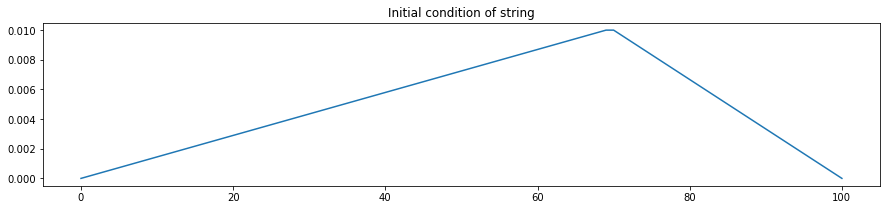

In [15]:
plt.figure(figsize=(15,3))
plt.plot(y0)
plt.title("Initial condition of string")

In [16]:
sol = np.zeros((Nt,Nx))

In [17]:
# set the first two rows of solution to y0
sol[0] = y0
sol[1] = y0

In [19]:
@numba.jit("f8[:,:](f8[:,:], i8, i8, f8, f8, f8, f8)", nopython=True, nogil=True)
def compute_d(d, times, length, dt, dx, l, gamma):
    for t in range(1, times-1):
        for i in range(2, length-2):
            outer_fact = (1/(c**2 * dt**2) + gamma/(2*dt))**(-1)
            p1 = 1/dx**2 * (d[t][i-1] - 2*d[t][i] + d[t][i+1])
            p2 = 1/(c**2 * dt**2) * (d[t-1][i] - 2*d[t][i])
            p3 = gamma/(2*dt) * d[t-1][i]
            p4 = l**2 / dx**4 * (d[t][i+2] - 4*d[t][i+1] + 6*d[t][i] - 4*d[t][i-1] + d[t][i-2])
            d[t+1][i] = outer_fact * (p1 - p2 + p3 - p4)
    return d

In [21]:
sol = compute_d(sol, Nt, Nx, dt, dx, l, gamma)

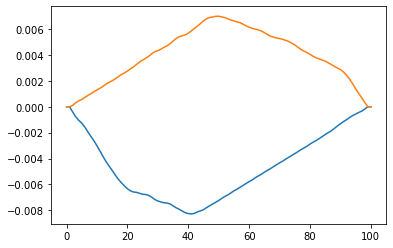

In [28]:
plt.plot(sol[500]) #t=500
plt.plot(sol[800]) #t=20000

In [29]:
1/dt

199999.99999999997

So it is 200_000 fps! Lets only index every 10 frames which gives 50000 fps. If we choose a gif fps of 50, this means our animation is moving 1000x solver than real life.

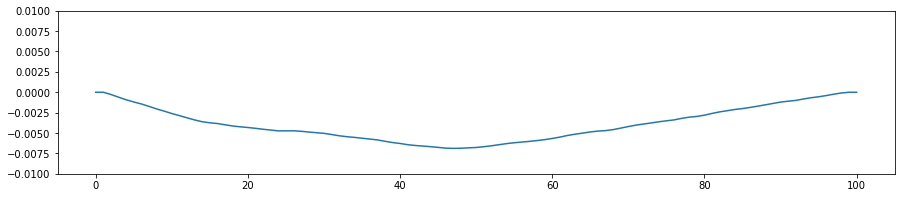

In [35]:
def animate(i):
    ax.clear()
    ax.plot(sol[i * 10])
    ax.set_ylim(-0.01, 0.01)


fig, ax = plt.subplots(1, 1, figsize=(15, 3))
ax.set_ylim(-0.01, 0.01)
ani = animation.FuncAnimation(fig, animate, frames=500, interval=50)
ani.save("string.gif", writer="pillow", fps=50)


# Create .WAV file of noise

Extract the amount of the harmonics at any time t:

$$\text{Amplitude of harmonic n at time t} ~\propto \int_{0}^{L}{y(x,t)sin(n \pi x/L)dx}$$

Then we need to add harmonics to get a single time-series.

In [80]:
def get_integral(n, sol):
    # At a given time, n, returns the amount of harmonic that is there.
    sin_arr = np.sin(n * np.pi * np.linspace(0, 1, 101))
    return np.array([sum(sin_arr * s) for s in sol])


In [40]:
# hms = harmonics
hms = [get_integral(n, sol) for n in range(10)]


Text(0.5, 1.0, 'The amount of 0 harmonic')

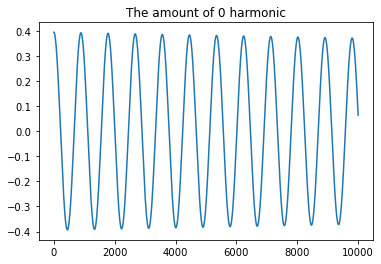

In [43]:
plt.figure()
plt.plot(hms[1][0:10_000])
plt.title("The amount of 1st harmonic")


Text(0.5, 1.0, 'The amount of 2nd harmonic')

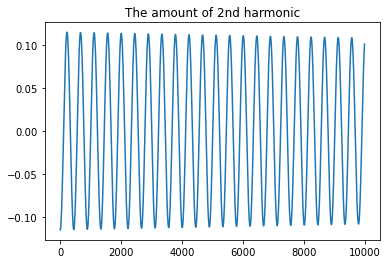

In [47]:
plt.figure()
plt.plot(hms[2][0:10_000])
plt.title("The amount of 2nd harmonic")


Add them together

In [48]:
tot = sum(hms)[::10]
tot = tot.astype(np.float32)


Text(0.5, 1.0, 'Sound time-series')

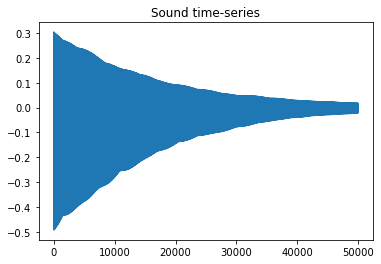

In [53]:
plt.figure()
plt.plot(tot)
plt.title("Sound time-series")


In [54]:
from scipy.io import wavfile
from IPython.display import Audio


In [56]:
wavfile.write("sound.wav", 20_000, tot)

In [83]:
import pandas

notes_df = pandas.read_csv("Notes.csv", names=["Name", "Frequency", "Wavelength"])


def to_date(series):
    series = series.replace("/","-")
    return series.strip()


notes_df["Name"] = notes_df["Name"].apply(to_date)

In [84]:
notes_df

,Name,Frequency,Wavelength
0,C0,16.35,2109.89
1,C#0-Db0,17.32,1991.47
2,D0,18.35,1879.69
3,D#0-Eb0,19.45,1774.20
4,E0,20.60,1674.62
...,...,...,...
103,G8,6271.93,5.50
104,G#8-Ab8,6644.88,5.19
105,A8,7040.00,4.90
106,A#8-Bb8,7458.62,4.63


In [81]:
def generate_note(name, frequency, i=0):
    Nx = 101
    Nt = 500_000
    L = 0.7
    dx = L/(Nx-1)
    f = frequency #Hz
    c = 2*L*f
    dt = 5e-6
    l = 2e-6
    gamma = 2.6e-5

    # 70+31 = Nx = 101
    ya = np.linspace(0, 0.01, 70)
    yb = np.linspace(0.01, 0, 31)
    y0 = np.concatenate([ya, yb])

    sol = np.zeros((Nt,Nx))

    # set the first two rows of solution to y0
    sol[0] = y0
    sol[1] = y0

    @numba.jit("f8[:,:](f8[:,:], i8, i8, f8, f8, f8, f8)", nopython=True, nogil=True)
    def compute_d(d, times, length, dt, dx, l, gamma):
        for t in range(1, times-1):
            for i in range(2, length-2):
                outer_fact = (1/(c**2 * dt**2) + gamma/(2*dt))**(-1)
                p1 = 1/dx**2 * (d[t][i-1] - 2*d[t][i] + d[t][i+1])
                p2 = 1/(c**2 * dt**2) * (d[t-1][i] - 2*d[t][i])
                p3 = gamma/(2*dt) * d[t-1][i]
                p4 = l**2 / dx**4 * (d[t][i+2] - 4*d[t][i+1] + 6*d[t][i] - 4*d[t][i-1] + d[t][i-2])
                d[t+1][i] = outer_fact * (p1 - p2 + p3 - p4)
        return d

    sol = compute_d(sol, Nt, Nx, dt, dx, l, gamma)

    # hms = harmonics
    hms = [get_integral(n, sol) for n in range(10)]

    tot = sum(hms)[::10]
    tot = tot.astype(np.float32)

    wavfile.write(f"{i} {name}.wav", 20_000, tot)


In [ ]:
i = 1
for index, row in notes_df.iterrows():
    generate_note(row['Name'], row['Frequency'], i)
    i += 1